## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Load Everything

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
'{DATA_PATH}\\train.csv'

'{DATA_PATH}\\train.csv'

In [5]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [6]:
#imputed_train = pd.read_csv('../input/imputed/imputed_4_correlated_train.csv',dtype = train_dtypes)

#imputed_test = pd.read_csv('../input/imputed/imputed_4_correlated_test.csv',dtype = train_dtypes)
# imputed_test['molecule_index'] = imputed_test.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')

In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [125]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [21]:
#base0, structures0 = build_type_dataframes(train_csv, structures_csv, coupling_type)

## Check LightGBM with the smallest type

In [133]:
%%time
#full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
#full['inv_1_0'] = 1 / full.d_1_0
print(full.shape)

(43363, 73)
Wall time: 1.28 s


In [134]:
full.head(15)

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.017257,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,0.012545,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.027377,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,0.017257,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,0.012545,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.027377,NaN,NaN,NaN,NaN,NaN,NaN,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,1,6,8,1,0,0,0,0,-0.908377,0.046467,1.071835,-0.961441,NaN,NaN,NaN,NaN,1.826796,-0.011743,-0.652588,-0.475004,NaN,NaN,NaN,NaN,0.018920,0.001204,-0.011133,0.008074,NaN,NaN,NaN,NaN,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,1,6,1,8,0,0,0,0,0.825355,0.046467,-0.961441,1.071835,NaN,NaN,NaN,NaN,1.885049,-0.011743,-0.475004,-0.652588,NaN,NaN,NaN,NaN,0.003738,0.001204,0.008074,-0.011133,NaN,NaN,NaN,NaN,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,225,19,7,2,54.063999,1.984051,-0.131759,0.386749,1.178267,-0.633243,0.056917,1,6,6,1,8,1,1,0,1.190494,-0.027404,0.006799,0.913903,-1.037220,-0.028261,-0.870809,NaN,-1.639196,-0.017521,1.499697,1.929238,-0.639807,1.785173,1.911242,NaN,0.100062,-0.148948,-0.025670,-0.461001,-0.407276,1.031491,-0.523452,NaN,1.004771,1.727509,1.006952,2.084700,1.369356,2.043309,2.596395,2.434870,3.357022,1.522602,2.472166,2.627629,3.622846,2.184789,3.164912,2.263603,2.493768,1.213961,2.853019,2.873019,3.752229,2.154795,3.626644,3.318123,4.152511,2.138156,NaN,NaN,NaN,NaN
6,229,19,8,2,56.186001,1.190494,-1.639196,0.100062,1.178267,-0.633243,0.056917,1,6,8,6,1,1,1,0,1.984051,-0.027404,-1.037220,0.006799,0.913903,-0.028261,-0.870809,NaN,-0.131759,-0.017521,-0.639807,1.499697,1.929238,1.785173,1.911242,NaN,0.386749,-0.148948,-0.407276,-0.025670,-0.461001,1.031491,-0.523452,NaN,1.006952,1.727509,1.004771,2.043309,1.369356,2.084700,2.493768,2.263603,3.164912,1.213961,3.357022,2.434870,2.596395,1.522602,3.622846,2.627629,2.472166,2.184789,3.752229,2.873019,2.853019,2.154795,4.152511,3.318123,3.626644,2.138156,NaN,NaN,NaN,NaN
7,389,32,4,0,37.719002,0.917298,1.835475,0.052027,-0.036081,1.487625,0.036781,1,6,1,1,6,7,0,0,-0.471622,-0.010395,0.528271,0.489462,-1.371810,-2.440267,NaN,NaN,1.856772,0.025176,-0.345333,-0.408804,-0.521089,-0.959564,NaN,NaN,-0.802756,-0.015066,0.864695,-0.897152,0.027393,0.033705,NaN,NaN,1.014969,1.631013,1.015277,2.035264,1.463593,2.046443,2.359597,2.088941,2.937592,1.096093,2.474020,2.178272,2.462809,1.102846,3.285424,2.412301,2.674642,1.46753

We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [137]:
full.columns

Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1',
       'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1',
       'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1',
       'd_9_2', 'd_9_3'],
      dtype='object')

For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [172]:
df = take_n_atoms(full, 7)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [173]:
df.head()

,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,0,0,0,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.688900
1,1,1,0,0,0,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.689098
2,1,1,0,0,0,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,32.690498
3,1,6,8,1,0,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,0.0,0.0,0.0,0.0,55.525200
4,1,6,1,8,0,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,0.0,0.0,0.0,0.0,54.735901


In [174]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 23), (8673, 23), (34690,), (8673,))

## CatBoost

In [175]:
from catboost import CatBoostRegressor

In [ ]:
params = {
          'learning_rate': 0.5,
           'max_depth': 3,    
           'n_estimators': 5000
         }
model = CatBoostRegressor(eval_metric='MAE', **params, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = ["atom_2", "atom_3", "atom_4",  "atom_5",  "atom_6"],
          use_best_model=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 47.2189354	test: 47.2745386	best: 47.2745386 (0)	total: 18ms	remaining: 1m 29s
1:	learn: 46.9691057	test: 47.0247378	best: 47.0247378 (1)	total: 34.3ms	remaining: 1m 25s
2:	learn: 46.7192353	test: 46.7748677	best: 46.7748677 (2)	total: 54.1ms	remaining: 1m 30s
3:	learn: 46.4694080	test: 46.5250436	best: 46.5250436 (3)	total: 70.2ms	remaining: 1m 27s
4:	learn: 46.2195375	test: 46.2751707	best: 46.2751707 (4)	total: 89.9ms	remaining: 1m 29s
5:	learn: 45.9696670	test: 46.0252996	best: 46.0252996 (5)	total: 106ms	remaining: 1m 27s
6:	learn: 45.7198398	test: 45.7754712	best: 45.7754712 (6)	total: 124ms	remaining: 1m 28s
7:	learn: 45.4699694	test: 45.5256018	best: 45.5256018 (7)	total: 140ms	remaining: 1m 27s
8:	learn: 45.2201422	test: 45.2757735	best: 45.2757735 (8)	total: 160ms	remaining: 1m 28s
9:	learn: 44.9703150	test: 45.0259454	best: 45.0259454 (9)	total: 176ms	remaining: 1m 27s
10:	learn: 44.7204380	test: 44.7760742	best: 44.7760742 (10)	total: 197ms	remaining: 1m 29s
11:	l

100:	learn: 22.2265476	test: 22.2825337	best: 22.2825337 (100)	total: 1.5s	remaining: 1m 12s
101:	learn: 21.9765909	test: 22.0326923	best: 22.0326923 (101)	total: 1.51s	remaining: 1m 12s
102:	learn: 21.7266341	test: 21.7828508	best: 21.7828508 (102)	total: 1.53s	remaining: 1m 12s
103:	learn: 21.4766773	test: 21.5330094	best: 21.5330094 (103)	total: 1.54s	remaining: 1m 12s
104:	learn: 21.2267206	test: 21.2831680	best: 21.2831680 (104)	total: 1.55s	remaining: 1m 12s
105:	learn: 20.9767638	test: 21.0333266	best: 21.0333266 (105)	total: 1.57s	remaining: 1m 12s
106:	learn: 20.7268070	test: 20.7834850	best: 20.7834850 (106)	total: 1.58s	remaining: 1m 12s
107:	learn: 20.4768503	test: 20.5336460	best: 20.5336460 (107)	total: 1.59s	remaining: 1m 12s
108:	learn: 20.2268935	test: 20.2838621	best: 20.2838621 (108)	total: 1.61s	remaining: 1m 12s
109:	learn: 19.9769367	test: 20.0340884	best: 20.0340884 (109)	total: 1.62s	remaining: 1m 12s
110:	learn: 19.7269800	test: 19.7843620	best: 19.7843620 (110

198:	learn: 4.5418706	test: 4.6350288	best: 4.6350288 (198)	total: 3.21s	remaining: 1m 17s
199:	learn: 4.4365867	test: 4.5296280	best: 4.5296280 (199)	total: 3.23s	remaining: 1m 17s
200:	learn: 4.3343027	test: 4.4273766	best: 4.4273766 (200)	total: 3.25s	remaining: 1m 17s
201:	learn: 4.2283540	test: 4.3212274	best: 4.3212274 (201)	total: 3.27s	remaining: 1m 17s
202:	learn: 4.1250575	test: 4.2179856	best: 4.2179856 (202)	total: 3.29s	remaining: 1m 17s
203:	learn: 4.0239369	test: 4.1164330	best: 4.1164330 (203)	total: 3.31s	remaining: 1m 17s
204:	learn: 3.9241553	test: 4.0166293	best: 4.0166293 (204)	total: 3.32s	remaining: 1m 17s
205:	learn: 3.8259090	test: 3.9180121	best: 3.9180121 (205)	total: 3.34s	remaining: 1m 17s
206:	learn: 3.7295641	test: 3.8204359	best: 3.8204359 (206)	total: 3.36s	remaining: 1m 17s
207:	learn: 3.6338798	test: 3.7242553	best: 3.7242553 (207)	total: 3.38s	remaining: 1m 17s
208:	learn: 3.5422244	test: 3.6312364	best: 3.6312364 (208)	total: 3.4s	remaining: 1m 17s


289:	learn: 1.1333946	test: 1.1599376	best: 1.1599376 (289)	total: 4.88s	remaining: 1m 19s
290:	learn: 1.1281847	test: 1.1544982	best: 1.1544982 (290)	total: 4.89s	remaining: 1m 19s
291:	learn: 1.1243171	test: 1.1495003	best: 1.1495003 (291)	total: 4.91s	remaining: 1m 19s
292:	learn: 1.1175053	test: 1.1421971	best: 1.1421971 (292)	total: 4.93s	remaining: 1m 19s
293:	learn: 1.1126744	test: 1.1370080	best: 1.1370080 (293)	total: 4.95s	remaining: 1m 19s
294:	learn: 1.1095499	test: 1.1332971	best: 1.1332971 (294)	total: 4.97s	remaining: 1m 19s
295:	learn: 1.1043491	test: 1.1274427	best: 1.1274427 (295)	total: 4.99s	remaining: 1m 19s
296:	learn: 1.1010908	test: 1.1247931	best: 1.1247931 (296)	total: 5s	remaining: 1m 19s
297:	learn: 1.0975814	test: 1.1209994	best: 1.1209994 (297)	total: 5.02s	remaining: 1m 19s
298:	learn: 1.0942636	test: 1.1175576	best: 1.1175576 (298)	total: 5.04s	remaining: 1m 19s
299:	learn: 1.0907776	test: 1.1136634	best: 1.1136634 (299)	total: 5.06s	remaining: 1m 19s
30

389:	learn: 0.8680901	test: 0.8846808	best: 0.8846808 (389)	total: 6.7s	remaining: 1m 19s
390:	learn: 0.8663037	test: 0.8826366	best: 0.8826366 (390)	total: 6.72s	remaining: 1m 19s
391:	learn: 0.8637309	test: 0.8795167	best: 0.8795167 (391)	total: 6.74s	remaining: 1m 19s
392:	learn: 0.8624275	test: 0.8783419	best: 0.8783419 (392)	total: 6.75s	remaining: 1m 19s
393:	learn: 0.8605879	test: 0.8768632	best: 0.8768632 (393)	total: 6.77s	remaining: 1m 19s
394:	learn: 0.8581296	test: 0.8746225	best: 0.8746225 (394)	total: 6.79s	remaining: 1m 19s
395:	learn: 0.8571284	test: 0.8735792	best: 0.8735792 (395)	total: 6.81s	remaining: 1m 19s
396:	learn: 0.8556379	test: 0.8722173	best: 0.8722173 (396)	total: 6.82s	remaining: 1m 19s
397:	learn: 0.8535441	test: 0.8698250	best: 0.8698250 (397)	total: 6.84s	remaining: 1m 19s
398:	learn: 0.8522681	test: 0.8693307	best: 0.8693307 (398)	total: 6.86s	remaining: 1m 19s
399:	learn: 0.8507093	test: 0.8672565	best: 0.8672565 (399)	total: 6.88s	remaining: 1m 19s


490:	learn: 0.7522039	test: 0.7752176	best: 0.7752176 (490)	total: 8.56s	remaining: 1m 18s
491:	learn: 0.7519506	test: 0.7749982	best: 0.7749982 (491)	total: 8.59s	remaining: 1m 18s
492:	learn: 0.7510705	test: 0.7744576	best: 0.7744576 (492)	total: 8.6s	remaining: 1m 18s
493:	learn: 0.7500716	test: 0.7735824	best: 0.7735824 (493)	total: 8.63s	remaining: 1m 18s
494:	learn: 0.7495840	test: 0.7731378	best: 0.7731378 (494)	total: 8.64s	remaining: 1m 18s
495:	learn: 0.7490858	test: 0.7729347	best: 0.7729347 (495)	total: 8.66s	remaining: 1m 18s
496:	learn: 0.7480652	test: 0.7718333	best: 0.7718333 (496)	total: 8.68s	remaining: 1m 18s
497:	learn: 0.7471595	test: 0.7711711	best: 0.7711711 (497)	total: 8.7s	remaining: 1m 18s
498:	learn: 0.7464222	test: 0.7704276	best: 0.7704276 (498)	total: 8.71s	remaining: 1m 18s
499:	learn: 0.7454576	test: 0.7695964	best: 0.7695964 (499)	total: 8.73s	remaining: 1m 18s
500:	learn: 0.7448116	test: 0.7689718	best: 0.7689718 (500)	total: 8.75s	remaining: 1m 18s
5

584:	learn: 0.6945538	test: 0.7227619	best: 0.7227619 (584)	total: 10.3s	remaining: 1m 17s
585:	learn: 0.6942723	test: 0.7225101	best: 0.7225101 (585)	total: 10.3s	remaining: 1m 17s
586:	learn: 0.6940974	test: 0.7224196	best: 0.7224196 (586)	total: 10.3s	remaining: 1m 17s
587:	learn: 0.6937380	test: 0.7218898	best: 0.7218898 (587)	total: 10.3s	remaining: 1m 17s
588:	learn: 0.6933163	test: 0.7213007	best: 0.7213007 (588)	total: 10.4s	remaining: 1m 17s
589:	learn: 0.6929539	test: 0.7210531	best: 0.7210531 (589)	total: 10.4s	remaining: 1m 17s
590:	learn: 0.6922948	test: 0.7204510	best: 0.7204510 (590)	total: 10.4s	remaining: 1m 17s
591:	learn: 0.6921854	test: 0.7202351	best: 0.7202351 (591)	total: 10.4s	remaining: 1m 17s
592:	learn: 0.6919659	test: 0.7199823	best: 0.7199823 (592)	total: 10.4s	remaining: 1m 17s
593:	learn: 0.6914087	test: 0.7193311	best: 0.7193311 (593)	total: 10.4s	remaining: 1m 17s
594:	learn: 0.6911544	test: 0.7189833	best: 0.7189833 (594)	total: 10.5s	remaining: 1m 17s

684:	learn: 0.6495545	test: 0.6818055	best: 0.6818055 (684)	total: 12.1s	remaining: 1m 16s
685:	learn: 0.6493540	test: 0.6815402	best: 0.6815402 (685)	total: 12.1s	remaining: 1m 16s
686:	learn: 0.6491672	test: 0.6813360	best: 0.6813360 (686)	total: 12.2s	remaining: 1m 16s
687:	learn: 0.6487398	test: 0.6811122	best: 0.6811122 (687)	total: 12.2s	remaining: 1m 16s
688:	learn: 0.6485261	test: 0.6810666	best: 0.6810666 (688)	total: 12.2s	remaining: 1m 16s
689:	learn: 0.6478599	test: 0.6805340	best: 0.6805340 (689)	total: 12.2s	remaining: 1m 16s
690:	learn: 0.6476398	test: 0.6803389	best: 0.6803389 (690)	total: 12.2s	remaining: 1m 16s
691:	learn: 0.6474073	test: 0.6801294	best: 0.6801294 (691)	total: 12.3s	remaining: 1m 16s
692:	learn: 0.6468673	test: 0.6796029	best: 0.6796029 (692)	total: 12.3s	remaining: 1m 16s
693:	learn: 0.6465346	test: 0.6790965	best: 0.6790965 (693)	total: 12.3s	remaining: 1m 16s
694:	learn: 0.6463166	test: 0.6789150	best: 0.6789150 (694)	total: 12.3s	remaining: 1m 16s

779:	learn: 0.6197344	test: 0.6558181	best: 0.6558181 (779)	total: 13.8s	remaining: 1m 14s
780:	learn: 0.6196940	test: 0.6558061	best: 0.6558061 (780)	total: 13.9s	remaining: 1m 14s
781:	learn: 0.6195170	test: 0.6555660	best: 0.6555660 (781)	total: 13.9s	remaining: 1m 14s
782:	learn: 0.6193176	test: 0.6554458	best: 0.6554458 (782)	total: 13.9s	remaining: 1m 14s
783:	learn: 0.6190515	test: 0.6553437	best: 0.6553437 (783)	total: 13.9s	remaining: 1m 14s
784:	learn: 0.6187166	test: 0.6550563	best: 0.6550563 (784)	total: 13.9s	remaining: 1m 14s
785:	learn: 0.6185654	test: 0.6550714	best: 0.6550563 (784)	total: 14s	remaining: 1m 14s
786:	learn: 0.6182806	test: 0.6549153	best: 0.6549153 (786)	total: 14s	remaining: 1m 14s
787:	learn: 0.6180278	test: 0.6546826	best: 0.6546826 (787)	total: 14s	remaining: 1m 14s
788:	learn: 0.6179115	test: 0.6545306	best: 0.6545306 (788)	total: 14s	remaining: 1m 14s
789:	learn: 0.6177407	test: 0.6544386	best: 0.6544386 (789)	total: 14s	remaining: 1m 14s
790:	lear

871:	learn: 0.5993611	test: 0.6388526	best: 0.6388526 (871)	total: 15.5s	remaining: 1m 13s
872:	learn: 0.5989899	test: 0.6386329	best: 0.6386329 (872)	total: 15.6s	remaining: 1m 13s
873:	learn: 0.5988403	test: 0.6385369	best: 0.6385369 (873)	total: 15.6s	remaining: 1m 13s
874:	learn: 0.5985329	test: 0.6383128	best: 0.6383128 (874)	total: 15.6s	remaining: 1m 13s
875:	learn: 0.5981109	test: 0.6378951	best: 0.6378951 (875)	total: 15.6s	remaining: 1m 13s
876:	learn: 0.5979765	test: 0.6378092	best: 0.6378092 (876)	total: 15.6s	remaining: 1m 13s
877:	learn: 0.5977954	test: 0.6376206	best: 0.6376206 (877)	total: 15.7s	remaining: 1m 13s
878:	learn: 0.5973737	test: 0.6370692	best: 0.6370692 (878)	total: 15.7s	remaining: 1m 13s
879:	learn: 0.5973243	test: 0.6370147	best: 0.6370147 (879)	total: 15.7s	remaining: 1m 13s
880:	learn: 0.5971878	test: 0.6369643	best: 0.6369643 (880)	total: 15.7s	remaining: 1m 13s
881:	learn: 0.5967545	test: 0.6366875	best: 0.6366875 (881)	total: 15.7s	remaining: 1m 13s

971:	learn: 0.5807589	test: 0.6219598	best: 0.6219598 (971)	total: 17.4s	remaining: 1m 12s
972:	learn: 0.5804866	test: 0.6217254	best: 0.6217254 (972)	total: 17.4s	remaining: 1m 12s
973:	learn: 0.5804568	test: 0.6217550	best: 0.6217254 (972)	total: 17.4s	remaining: 1m 12s
974:	learn: 0.5802657	test: 0.6214197	best: 0.6214197 (974)	total: 17.5s	remaining: 1m 12s
975:	learn: 0.5798929	test: 0.6211384	best: 0.6211384 (975)	total: 17.5s	remaining: 1m 12s
976:	learn: 0.5796406	test: 0.6208042	best: 0.6208042 (976)	total: 17.5s	remaining: 1m 12s
977:	learn: 0.5794590	test: 0.6205759	best: 0.6205759 (977)	total: 17.5s	remaining: 1m 12s
978:	learn: 0.5790609	test: 0.6202027	best: 0.6202027 (978)	total: 17.5s	remaining: 1m 12s
979:	learn: 0.5788162	test: 0.6199072	best: 0.6199072 (979)	total: 17.5s	remaining: 1m 11s
980:	learn: 0.5786974	test: 0.6199168	best: 0.6199072 (979)	total: 17.6s	remaining: 1m 11s
981:	learn: 0.5786319	test: 0.6198416	best: 0.6198416 (981)	total: 17.6s	remaining: 1m 11s

1063:	learn: 0.5648731	test: 0.6092061	best: 0.6091597 (1061)	total: 19.1s	remaining: 1m 10s
1064:	learn: 0.5647825	test: 0.6090646	best: 0.6090646 (1064)	total: 19.1s	remaining: 1m 10s
1065:	learn: 0.5645247	test: 0.6087110	best: 0.6087110 (1065)	total: 19.1s	remaining: 1m 10s
1066:	learn: 0.5644587	test: 0.6087127	best: 0.6087110 (1065)	total: 19.2s	remaining: 1m 10s
1067:	learn: 0.5643621	test: 0.6086835	best: 0.6086835 (1067)	total: 19.2s	remaining: 1m 10s
1068:	learn: 0.5642879	test: 0.6086253	best: 0.6086253 (1068)	total: 19.2s	remaining: 1m 10s
1069:	learn: 0.5642397	test: 0.6086094	best: 0.6086094 (1069)	total: 19.2s	remaining: 1m 10s
1070:	learn: 0.5641731	test: 0.6086166	best: 0.6086094 (1069)	total: 19.2s	remaining: 1m 10s
1071:	learn: 0.5641411	test: 0.6084977	best: 0.6084977 (1071)	total: 19.3s	remaining: 1m 10s
1072:	learn: 0.5640177	test: 0.6083919	best: 0.6083919 (1072)	total: 19.3s	remaining: 1m 10s
1073:	learn: 0.5639245	test: 0.6083151	best: 0.6083151 (1073)	total: 1

1157:	learn: 0.5525273	test: 0.5987513	best: 0.5987513 (1157)	total: 20.8s	remaining: 1m 9s
1158:	learn: 0.5524681	test: 0.5986819	best: 0.5986819 (1158)	total: 20.9s	remaining: 1m 9s
1159:	learn: 0.5522520	test: 0.5985053	best: 0.5985053 (1159)	total: 20.9s	remaining: 1m 9s
1160:	learn: 0.5518378	test: 0.5982296	best: 0.5982296 (1160)	total: 20.9s	remaining: 1m 9s
1161:	learn: 0.5517839	test: 0.5982315	best: 0.5982296 (1160)	total: 20.9s	remaining: 1m 9s
1162:	learn: 0.5516285	test: 0.5979776	best: 0.5979776 (1162)	total: 20.9s	remaining: 1m 9s
1163:	learn: 0.5514821	test: 0.5977792	best: 0.5977792 (1163)	total: 21s	remaining: 1m 9s
1164:	learn: 0.5513117	test: 0.5975371	best: 0.5975371 (1164)	total: 21s	remaining: 1m 9s
1165:	learn: 0.5512637	test: 0.5973999	best: 0.5973999 (1165)	total: 21s	remaining: 1m 9s
1166:	learn: 0.5511946	test: 0.5973721	best: 0.5973721 (1166)	total: 21s	remaining: 1m 9s
1167:	learn: 0.5510587	test: 0.5971518	best: 0.5971518 (1167)	total: 21s	remaining: 1m 9

1249:	learn: 0.5424349	test: 0.5909184	best: 0.5909184 (1249)	total: 22.5s	remaining: 1m 7s
1250:	learn: 0.5422846	test: 0.5907083	best: 0.5907083 (1250)	total: 22.6s	remaining: 1m 7s
1251:	learn: 0.5421136	test: 0.5907002	best: 0.5907002 (1251)	total: 22.6s	remaining: 1m 7s
1252:	learn: 0.5420314	test: 0.5906130	best: 0.5906130 (1252)	total: 22.6s	remaining: 1m 7s
1253:	learn: 0.5417610	test: 0.5903079	best: 0.5903079 (1253)	total: 22.6s	remaining: 1m 7s
1254:	learn: 0.5415580	test: 0.5900466	best: 0.5900466 (1254)	total: 22.6s	remaining: 1m 7s
1255:	learn: 0.5414901	test: 0.5899820	best: 0.5899820 (1255)	total: 22.6s	remaining: 1m 7s
1256:	learn: 0.5414138	test: 0.5899325	best: 0.5899325 (1256)	total: 22.7s	remaining: 1m 7s
1257:	learn: 0.5410823	test: 0.5897309	best: 0.5897309 (1257)	total: 22.7s	remaining: 1m 7s
1258:	learn: 0.5408434	test: 0.5894762	best: 0.5894762 (1258)	total: 22.7s	remaining: 1m 7s
1259:	learn: 0.5407432	test: 0.5892971	best: 0.5892971 (1259)	total: 22.7s	remai

1340:	learn: 0.5324332	test: 0.5819242	best: 0.5819242 (1340)	total: 24.2s	remaining: 1m 6s
1341:	learn: 0.5323800	test: 0.5819322	best: 0.5819242 (1340)	total: 24.2s	remaining: 1m 6s
1342:	learn: 0.5321134	test: 0.5816769	best: 0.5816769 (1342)	total: 24.2s	remaining: 1m 6s
1343:	learn: 0.5320291	test: 0.5815569	best: 0.5815569 (1343)	total: 24.3s	remaining: 1m 5s
1344:	learn: 0.5319178	test: 0.5814123	best: 0.5814123 (1344)	total: 24.3s	remaining: 1m 5s
1345:	learn: 0.5318846	test: 0.5814209	best: 0.5814123 (1344)	total: 24.3s	remaining: 1m 5s
1346:	learn: 0.5318618	test: 0.5813930	best: 0.5813930 (1346)	total: 24.3s	remaining: 1m 5s
1347:	learn: 0.5317868	test: 0.5812844	best: 0.5812844 (1347)	total: 24.3s	remaining: 1m 5s
1348:	learn: 0.5317724	test: 0.5812788	best: 0.5812788 (1348)	total: 24.3s	remaining: 1m 5s
1349:	learn: 0.5317371	test: 0.5812921	best: 0.5812788 (1348)	total: 24.4s	remaining: 1m 5s
1350:	learn: 0.5316152	test: 0.5811785	best: 0.5811785 (1350)	total: 24.4s	remai

1431:	learn: 0.5234358	test: 0.5746269	best: 0.5746269 (1431)	total: 25.9s	remaining: 1m 4s
1432:	learn: 0.5233416	test: 0.5746217	best: 0.5746217 (1432)	total: 25.9s	remaining: 1m 4s
1433:	learn: 0.5232155	test: 0.5745496	best: 0.5745496 (1433)	total: 25.9s	remaining: 1m 4s
1434:	learn: 0.5231555	test: 0.5744703	best: 0.5744703 (1434)	total: 25.9s	remaining: 1m 4s
1435:	learn: 0.5230651	test: 0.5744011	best: 0.5744011 (1435)	total: 25.9s	remaining: 1m 4s
1436:	learn: 0.5230222	test: 0.5743495	best: 0.5743495 (1436)	total: 26s	remaining: 1m 4s
1437:	learn: 0.5229235	test: 0.5742534	best: 0.5742534 (1437)	total: 26s	remaining: 1m 4s
1438:	learn: 0.5228554	test: 0.5742870	best: 0.5742534 (1437)	total: 26s	remaining: 1m 4s
1439:	learn: 0.5227337	test: 0.5740348	best: 0.5740348 (1439)	total: 26s	remaining: 1m 4s
1440:	learn: 0.5226657	test: 0.5739647	best: 0.5739647 (1440)	total: 26s	remaining: 1m 4s
1441:	learn: 0.5225761	test: 0.5738474	best: 0.5738474 (1441)	total: 26.1s	remaining: 1m 4

1521:	learn: 0.5155453	test: 0.5680517	best: 0.5680517 (1521)	total: 27.6s	remaining: 1m 2s
1522:	learn: 0.5154786	test: 0.5679690	best: 0.5679690 (1522)	total: 27.6s	remaining: 1m 2s
1523:	learn: 0.5154231	test: 0.5679642	best: 0.5679642 (1523)	total: 27.6s	remaining: 1m 2s
1524:	learn: 0.5152974	test: 0.5679625	best: 0.5679625 (1524)	total: 27.6s	remaining: 1m 2s
1525:	learn: 0.5152621	test: 0.5679820	best: 0.5679625 (1524)	total: 27.6s	remaining: 1m 2s
1526:	learn: 0.5152512	test: 0.5679493	best: 0.5679493 (1526)	total: 27.7s	remaining: 1m 2s
1527:	learn: 0.5151941	test: 0.5679309	best: 0.5679309 (1527)	total: 27.7s	remaining: 1m 2s
1528:	learn: 0.5151169	test: 0.5678415	best: 0.5678415 (1528)	total: 27.7s	remaining: 1m 2s
1529:	learn: 0.5150628	test: 0.5678351	best: 0.5678351 (1529)	total: 27.7s	remaining: 1m 2s
1530:	learn: 0.5150147	test: 0.5677283	best: 0.5677283 (1530)	total: 27.7s	remaining: 1m 2s
1531:	learn: 0.5149529	test: 0.5676989	best: 0.5676989 (1531)	total: 27.7s	remai

1612:	learn: 0.5071017	test: 0.5616055	best: 0.5616055 (1612)	total: 29.2s	remaining: 1m 1s
1613:	learn: 0.5070352	test: 0.5615264	best: 0.5615264 (1613)	total: 29.3s	remaining: 1m 1s
1614:	learn: 0.5070162	test: 0.5615059	best: 0.5615059 (1614)	total: 29.3s	remaining: 1m 1s
1615:	learn: 0.5069175	test: 0.5613715	best: 0.5613715 (1615)	total: 29.3s	remaining: 1m 1s
1616:	learn: 0.5067572	test: 0.5613543	best: 0.5613543 (1616)	total: 29.3s	remaining: 1m 1s
1617:	learn: 0.5067319	test: 0.5613048	best: 0.5613048 (1617)	total: 29.3s	remaining: 1m 1s
1618:	learn: 0.5066597	test: 0.5612781	best: 0.5612781 (1618)	total: 29.4s	remaining: 1m 1s
1619:	learn: 0.5065376	test: 0.5612412	best: 0.5612412 (1619)	total: 29.4s	remaining: 1m 1s
1620:	learn: 0.5065199	test: 0.5612236	best: 0.5612236 (1620)	total: 29.4s	remaining: 1m 1s
1621:	learn: 0.5063608	test: 0.5611724	best: 0.5611724 (1621)	total: 29.4s	remaining: 1m 1s
1622:	learn: 0.5062635	test: 0.5611239	best: 0.5611239 (1622)	total: 29.4s	remai

1704:	learn: 0.4990061	test: 0.5550365	best: 0.5550365 (1704)	total: 30.9s	remaining: 59.8s
1705:	learn: 0.4989171	test: 0.5549516	best: 0.5549516 (1705)	total: 31s	remaining: 59.8s
1706:	learn: 0.4988365	test: 0.5549668	best: 0.5549516 (1705)	total: 31s	remaining: 59.7s
1707:	learn: 0.4988336	test: 0.5549611	best: 0.5549516 (1705)	total: 31s	remaining: 59.7s
1708:	learn: 0.4988015	test: 0.5548623	best: 0.5548623 (1708)	total: 31s	remaining: 59.7s
1709:	learn: 0.4986705	test: 0.5546552	best: 0.5546552 (1709)	total: 31s	remaining: 59.7s
1710:	learn: 0.4986123	test: 0.5545315	best: 0.5545315 (1710)	total: 31s	remaining: 59.7s
1711:	learn: 0.4985015	test: 0.5543648	best: 0.5543648 (1711)	total: 31.1s	remaining: 59.6s
1712:	learn: 0.4984527	test: 0.5544148	best: 0.5543648 (1711)	total: 31.1s	remaining: 59.6s
1713:	learn: 0.4984338	test: 0.5543918	best: 0.5543648 (1711)	total: 31.1s	remaining: 59.6s
1714:	learn: 0.4983335	test: 0.5542360	best: 0.5542360 (1714)	total: 31.1s	remaining: 59.6s


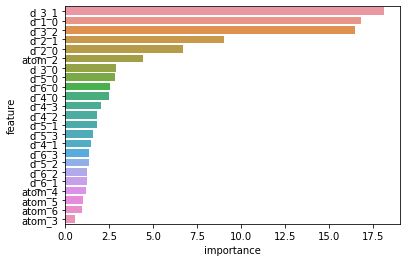

In [163]:
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [157]:
X_train.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3
count,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000,34690.000000
mean,4.224733,5.984491,4.007985,4.345200,4.537158,0.987332,0.531782,0.822288,0.474235,0.667205,0.527732,0.394237,0.437828,0.472774,0.667579,0.359631,0.412804,0.462751,0.573635,0.326222,0.392944,0.439337,0.539439
std,2.457268,1.073634,2.960855,2.806065,2.710155,0.005710,0.050975,0.130852,0.028029,0.098783,0.119426,0.041435,0.038449,0.224044,0.226094,0.052381,0.044975,0.198082,0.219260,0.049999,0.055660,0.166768,0.201155
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.875597,0.432162,0.638311,0.331506,0.345103,0.325240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,6.000000,1.000000,1.000000,1.000000,0.982747,0.487837,0.719192,0.468465,0.675163,0.444227,0.374231,0.411979,0.306124,0.450792,0.315654,0.388561,0.313162,0.378187,0.296369,0.356558,0.338845,0.370081
50%,6.000000,6.000000,6.000000,6.000000,6.000000,0.987912,0.521082,0.776327,0.484292,0.691017,0.491060,0.398764,0.441046,0.341681,0.721331,0.367255,0.413616,0.392128,0.640323,0.316938,0.398598,0.395858,0.462523
75%,6.000000,6.000000,7.000000,6.000000,6.000000,0.992230,0.585113,0.986920,0.491228,0.723825,0.658891,0.424710,0.465262,0.661876,0.911890,0.399555,0.448691,0.643068,0.729730,0.362144,0.436462,0.463373,0.711312
max,7.000000,8.000000,9.000000,9.000000,9.000000,0.997764,0.624459,0.997433,0.617778,0.985020,0.921412,0.632708,0.683211,0.931205,0.995053,0.699003,0.546242,0.929541,1.038267,0.534030,0.543753,0.927837,1.014043


## LGBMRegressor

In [152]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 30,
    'min_child_samples': 79,
    'max_depth': 2,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [ ]:

model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Not a bad score for such a simple set of features.

In [ ]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model
do not need now

In [ ]:
asfasdfasdf

In [ ]:

def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [ ]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=600, n_jobs = -1)
        #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [ ]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 5
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

Checking cross-validation scores for each type:

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## Room for improvement

There are many steps, how to improve the score for this kernel:
* Tune LGB hyperparameters - I did nothing for this
* Tune number of atoms for each type
* Try to add other features
* Play with categorical features for atom types (one-hot-encoding, CatBoost?)
* Try other tree libraries

Also, this representation fails badly on `*JHC` coupling types. The main reason for this is that 3rd and 4th atoms are usually located on the same distance and representation starts "jittering" randomly picking one of them. So, two similar configurations will have different representation due to usage of 3/4 of 4/3 distances.

The biggest challenge would be to implement handcrafted KNN with some compiled language(Rust, C++, C).

Would be cool to see this kernel forked and addressed some of the issues with higher LB score.